In [1]:
!wget -O data.zip "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip"

--2022-02-18 11:23:09--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/4drtyfjtfy-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.29.24
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.29.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95592747 (91M) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>]  91.16M  20.5MB/s    in 5.3s    

2022-02-18 11:23:15 (17.2 MB/s) - ‘data.zip’ saved [95592747/95592747]



In [2]:
!unzip data.zip

Archive:  data.zip
  inflating: dataset2.zip            


In [3]:
!unzip -q dataset2.zip

In [4]:
import glob, os, shutil

In [5]:
types = [
  ("Cloudy", "cloud*.*"), ("Rainy" , "rain*.*"), ("Shiny", "shin*.*"), ("Sunrise","sunrise*.*")       
]

shutil.rmtree("dataset", ignore_errors=True)
for folder_name, file_mask in types:
  os.makedirs(f"dataset/Train/{folder_name}")
  os.makedirs(f"dataset/Test/{folder_name}")
  files = sorted( glob.glob(f"dataset2/{file_mask}") )
  train_qnty = int(0.8*len(files))
    
  [ shutil.copy(file, f"dataset/Train/{folder_name}")  for file in files[:train_qnty]  ]
  [ shutil.copy(file, f"dataset/Test/{folder_name}")  for file in files[train_qnty:]  ]
  print(folder_name, file_mask, len(files))

Cloudy cloud*.* 300
Rainy rain*.* 215
Shiny shin*.* 253
Sunrise sunrise*.* 357


In [6]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array

In [7]:
!wget -O cup.jpg "https://lh5.googleusercontent.com/sTDIn5BK6czLJsB9u-m-VcLma4a6IbJ6rKL0NC3Vp8XESJuAoc5detOT9wtNobOX2CvCX4Qtel21vr7R3Jnv13MrbNIy-yhb-4z6H08wIthMXhce8mjglvufpLOzgx0ftFbvGphn"

--2022-02-18 11:23:19--  https://lh5.googleusercontent.com/sTDIn5BK6czLJsB9u-m-VcLma4a6IbJ6rKL0NC3Vp8XESJuAoc5detOT9wtNobOX2CvCX4Qtel21vr7R3Jnv13MrbNIy-yhb-4z6H08wIthMXhce8mjglvufpLOzgx0ftFbvGphn
Resolving lh5.googleusercontent.com (lh5.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c0c::84
Connecting to lh5.googleusercontent.com (lh5.googleusercontent.com)|74.125.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30838 (30K) [image/jpeg]
Saving to: ‘cup.jpg’

cup.jpg             100%[===================>]  30.12K  --.-KB/s    in 0s      

2022-02-18 11:23:19 (133 MB/s) - ‘cup.jpg’ saved [30838/30838]



In [8]:
img = load_img("cup.jpg", target_size=(224,224))
x = img_to_array(img)
x = x.reshape( (1,)+x.shape  )
x.shape

(1, 224, 224, 3)

In [9]:
# inicjalizacja sieci
model = VGG16()
predict = model.predict( preprocess_input(x) )

553476096/553467096 [==============================] - 2s 0us/step


In [10]:
decode_predictions(predict, top=10)

49152/35363 [=========================================] - 0s 0us/step


[[('n03063599', 'coffee_mug', 0.2533003),
  ('n07930864', 'cup', 0.17093909),
  ('n04263257', 'soup_bowl', 0.16099045),
  ('n07920052', 'espresso', 0.14152709),
  ('n03733805', 'measuring_cup', 0.082045786),
  ('n04398044', 'teapot', 0.04722244),
  ('n03775546', 'mixing_bowl', 0.044552166),
  ('n03786901', 'mortar', 0.024030173),
  ('n03950228', 'pitcher', 0.014153445),
  ('n04332243', 'strainer', 0.010426586)]]

In [11]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [31]:
# tworzymy nowa sieci na bazie starej
model = VGG16(include_top=False, input_shape=(224, 224, 3))

# wyłączenie z trenowania istniejących warstw
for layer in model.layers:
  layer.trainable = False

# konwersja warstwy wyjsciowej istniejacego modelu na nową wartst wyjsciowa
hidden = Flatten()(model.output)
outputs = Dense(4, activation="softmax")(hidden)

# tworzymy nowy model na podstawie istniejącego modelu
model = Model(inputs=model.input, outputs=outputs)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
train_data_gen = ImageDataGenerator(
    rescale=1/255, shear_range=0.5, zoom_range=0.7, 
    horizontal_flip=True, vertical_flip=True
)

test_data_gen = ImageDataGenerator(
    rescale=1/255
)

In [34]:
train_data = train_data_gen.flow_from_directory("dataset/Train", 
                                                target_size=(224,224), 
                                                class_mode="categorical")

test_data = train_data_gen.flow_from_directory("dataset/Test", 
                                                target_size=(224,224), 
                                                class_mode="categorical")

Found 899 images belonging to 4 classes.
Found 226 images belonging to 4 classes.


In [35]:
test_data.class_indices

{'Cloudy': 0, 'Rainy': 1, 'Shiny': 2, 'Sunrise': 3}

In [36]:
from keras.callbacks import ModelCheckpoint

In [37]:
mcp = ModelCheckpoint("/content/drive/MyDrive/vgg16-v1.h5", save_best_only=True)
result = model.fit_generator(train_data, epochs=100, validation_data=test_data, callbacks=[mcp])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/100
29/29 [==============================] - 20s 674ms/step - loss: 1.2853 - accuracy: 0.5261 - val_loss: 0.7086 - val_accuracy: 0.7257
Epoch 2/100
29/29 [==============================] - 20s 684ms/step - loss: 0.5264 - accuracy: 0.8109 - val_loss: 0.4511 - val_accuracy: 0.8407
Epoch 3/100
29/29 [==============================] - 20s 693ms/step - loss: 0.4000 - accuracy: 0.8554 - val_loss: 0.4458 - val_accuracy: 0.8142
Epoch 4/100
29/29 [==============================] - 20s 696ms/step - loss: 0.3814 - accuracy: 0.8732 - val_loss: 0.3498 - val_accuracy: 0.8850
Epoch 5/100
29/29 [==============================] - 19s 647ms/step - loss: 0.3492 - accuracy: 0.8710 - val_loss: 0.3937 - val_accuracy: 0.8628
Epoch 6/100
29/29 [==============================] - 18s 636ms/step - loss: 0.3107 - accuracy: 0.8954 - val_loss: 0.4164 - val_accuracy: 0.8319
Epoch 7/100
29/29 [==============================] - 19s 658ms/step - loss: 0.3138 - accuracy: 0.8888 - val_loss: 0.2281 - val_accuracy:

In [38]:
import pandas as pd

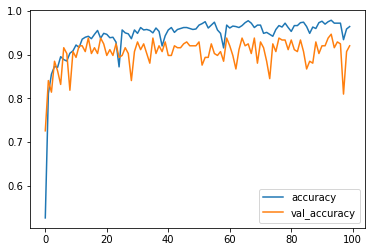

In [39]:
pd.DataFrame(result.history)[ ["accuracy","val_accuracy"] ].plot()

In [40]:
!wget -O "sky.jpg" "https://thumbs.dreamstime.com/b/bright-blue-cloudy-sky-background-texture-photo-42976329.jpg"

#img = load_img("sky.jpg", target_size=(224,224))
img = load_img("/content/dataset/Test/Cloudy/cloudy6.jpg", target_size=(224,224))

x = img_to_array(img)
x = x.reshape( (1,)+x.shape  )

prediction = model.predict( preprocess_input(x) )
print(prediction)
np.argmax(prediction)

--2022-02-18 12:13:14--  https://thumbs.dreamstime.com/b/bright-blue-cloudy-sky-background-texture-photo-42976329.jpg
Resolving thumbs.dreamstime.com (thumbs.dreamstime.com)... 192.229.163.122
Connecting to thumbs.dreamstime.com (thumbs.dreamstime.com)|192.229.163.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58554 (57K) [image/jpeg]
Saving to: ‘sky.jpg’

sky.jpg             100%[===================>]  57.18K  --.-KB/s    in 0.007s  

2022-02-18 12:13:14 (7.52 MB/s) - ‘sky.jpg’ saved [58554/58554]

[[0.00000000e+00 0.00000000e+00 1.00000000e+00 1.00127544e-14]]


2

In [41]:
test_data.class_indices

{'Cloudy': 0, 'Rainy': 1, 'Shiny': 2, 'Sunrise': 3}